In [1]:
# Author: Giuliano Paladino - Sentinela

import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

## Análise Exploratória de Dados

### Estatística Descritiva

In [2]:
data = pd.read_csv("data/all_data.csv", parse_dates=["BO_INICIADO", "BO_EMITIDO", "DATAOCORRENCIA", "DATACOMUNICACAO", "DATAELABORACAO"], low_memory=False)
del(data['Unnamed: 0'])

In [3]:
data.columns

Index(['ANO_BO', 'NUM_BO', 'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO',
       'DATAOCORRENCIA', 'PERIDOOCORRENCIA', 'DATACOMUNICACAO',
       'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE', 'NUMERO_BOLETIM_PRINCIPAL',
       'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'UF', 'LATITUDE',
       'LONGITUDE', 'DESCRICAOLOCAL', 'EXAME', 'SOLUCAO', 'DELEGACIA_NOME',
       'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA', 'DESDOBRAMENTO',
       'STATUS', 'NOMEPESSOA', 'TIPOPESSOA', 'VITIMAFATAL', 'RG', 'RG_UF',
       'NATURALIDADE', 'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE',
       'ESTADOCIVIL', 'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS',
       'NATUREZAVINCULADA', 'TIPOVINCULO', 'PLACA_VEICULO', 'UF_VEICULO',
       'CIDADE_VEICULO', 'DESCR_COR_VEICULO', 'DESCR_MARCA_VEICULO',
       'ANO_FABRICACAO', 'ANO_MODELO', 'DESCR_TIPO_VEICULO'],
      dtype='object')

In [4]:
data.groupby('CIDADE').size()

CIDADE
ADAMANTINA                  17
ADOLFO                       4
AGUAI                       35
AGUAS DA PRATA              11
AGUAS DE LINDOIA            43
AGUAS DE SANTA BARBARA       1
AGUAS DE SAO PEDRO           2
AGUDOS                      68
ALTAIR                       2
ALTINOPOLIS                 20
ALUMINIO                    26
ALVARES MACHADO             24
AMERICANA                 1731
AMERICO BRASILIENSE         19
AMERICO DE CAMPOS            4
AMPARO                      88
ANALANDIA                    6
ANDRADINA                   44
ANGATUBA                    32
ANHEMBI                      2
APARECIDA                  163
APARECIDA D OESTE            9
APIAI                        6
ARACARIGUAMA               262
ARACATUBA                  419
ARACOIABA DA SERRA          92
ARAMINA                      7
ARANDU                       1
ARARAQUARA                 488
ARARAS                     440
                          ... 
TAUBATE                   1043
T

In [ ]:
# Verificando o skew de cada atributo
# Skew (ou simetria) se refere a distribuição dos dados que é assumida ser normal ou gaussiana (bell curve). 
data.skew()

In [ ]:
# Matriz de Correlação com nomes das variáveis
data.corr(method = 'pearson')

In [ ]:
data.hist()
plt.show()

In [ ]:
data.info()

In [ ]:
# Visualizando as dimensões
data.shape

In [ ]:
# Tipo de dados de cada atributo
data.dtypes

In [ ]:
# Sumário estatístico
data.describe()

In [ ]:
data.groupby(['DIA_MES','MARCA','LATITUDE', 'LONGITUDE']).size()

In [ ]:
plt.plot(data['LATITUDE'],data['LONGITUDE'],'.')
plt.show()

## Pré-processamento dos dados, passou de quase 320k linhas para 177k linhas.

In [5]:
# Filtro os dados apenas em roubo ou furto -> há muitas linhas para outros crimes relacionados ao roubo e furto.
data.loc[data.RUBRICA == "Roubo (art. 157) - VEICULO",'ATO'] = "Roubo - VEICULO"
data.loc[data.RUBRICA == "A.I.-Roubo (art. 157) - VEICULO",'ATO'] = "Roubo - VEICULO"
data.loc[data.RUBRICA == "Furto (art. 155) - VEICULO",'ATO'] = "Furto - VEICULO"
data.loc[data.RUBRICA == "A.I.-Furto (art. 155) - VEICULO",'ATO'] = "Furto - VEICULO"
data.loc[data.RUBRICA == "Furto qualificado (art. 155, §4o.) - VEICULO",'ATO'] = "Furto - VEICULO"
data.loc[data.RUBRICA == "A.I.-Furto qualificado (art. 155, §4o.) - VEICULO",'ATO'] = "Furto - VEICULO"
data.loc[data.RUBRICA == "Furto de coisa comum (art. 156) - VEICULO",'ATO'] = "Furto - VEICULO"

query = (data.ATO == "Roubo - VEICULO") | (data.ATO == "Furto - VEICULO") & (data.CIDADE == 'S.PAULO')
data = data.loc[query, :]
data = data[data.DATAOCORRENCIA.dt.year == 2017]

#data.ATO.value_counts()

In [6]:
# Remove entradas duplicadas, adicione os recursos WEEKDAY (DIA_DA_SEMANA) e MONTH (MES)
data = data.drop_duplicates(subset=['NUM_BO','PLACA_VEICULO','DESCR_MARCA_VEICULO'])
data['Count'] = data.groupby(['NUM_BO'])['NUM_BO'].transform('count')
data['DIA_DA_SEMANA'] = data.loc[:,'DATAOCORRENCIA'].dt.weekday_name
data['MES'] = data.loc[:,'DATAOCORRENCIA'].dt.month
data['DIA_MES'] = data.loc[:,'DATAOCORRENCIA'].dt.day
data['ANO'] = data.loc[:,'DATAOCORRENCIA'].dt.year
data = data.drop_duplicates(subset=['PLACA_VEICULO','MES'])
data = data[(data['DESCR_MARCA_VEICULO'].notnull()) | 
            (data['UF_VEICULO'].notnull()) |
            (data['CIDADE_VEICULO'].notnull()) | 
            (data['PLACA_VEICULO'].notnull())]
data.loc[data.ANO_FABRICACAO == 0] = np.nan
data.loc[data.ANO_MODELO == 0] = np.nan
data = data.loc[data.NUM_BO.notnull()]
data['DATAOCORRENCIA'] = data.DATAOCORRENCIA.dt.date

In [7]:
# Agregando categorias de veículos similares em um novo recurso: TIPO_VEICULO
data.loc[(data['DESCR_TIPO_VEICULO'] == "MOTONETA") | (data['DESCR_TIPO_VEICULO'] == "MOTOCICLO") | (data['DESCR_TIPO_VEICULO'] == "CICLOMOTO"),'TIPO_VEICULO'] = "MOTO"
data.loc[(data['DESCR_TIPO_VEICULO'] == "CAMINHONETE") | (data['DESCR_TIPO_VEICULO'] == "CAMIONETA") | (data['DESCR_TIPO_VEICULO'] == "UTILIT?RIO") | (data['DESCR_TIPO_VEICULO'] == "AUTOMOVEL"),'TIPO_VEICULO'] = "AUTOMOVEL"
data.loc[(data['DESCR_TIPO_VEICULO'] == "CAMINH?O") | (data['DESCR_TIPO_VEICULO'] == "CAMINH?O TRATOR") | (data['DESCR_TIPO_VEICULO'] == "SEMI-REBOQUE") | (data['DESCR_TIPO_VEICULO'] == "REBOQUE"),'TIPO_VEICULO'] = "CAMINHAO"
data.loc[(data['DESCR_TIPO_VEICULO'] == "MICRO-ONIBUS") | (data['DESCR_TIPO_VEICULO'] == "ONIBUS"),'TIPO_VEICULO'] = "ONIBUS"
data.loc[(data['TIPO_VEICULO'].isnull()) & (data['DESCR_TIPO_VEICULO'].notnull()),'TIPO_VEICULO'] = "OUTROS"

In [8]:
# LIMPEZA DO NOME DO VEÍCULO
data.loc[(data['DESCR_MARCA_VEICULO'].str[0:2] == "I/") | (data['DESCR_MARCA_VEICULO'].str[0:2] == "H/") | (data['DESCR_MARCA_VEICULO'].str[0:2] == "R/"),'DESCR_MARCA_VEICULO'] = data['DESCR_MARCA_VEICULO'].str[2:]
data.loc[data['DESCR_MARCA_VEICULO'].str[0:4] == "IMP/",'DESCR_MARCA_VEICULO'] = data['DESCR_MARCA_VEICULO'].str[4:]
data.loc[:,'DESCR_MARCA_VEICULO'] = data['DESCR_MARCA_VEICULO'].str.replace("NOVO ","")
data.loc[:,'DESCR_MARCA_VEICULO'] = data['DESCR_MARCA_VEICULO'].str.replace("NOVA ","")

In [9]:
# Criando 2 novos recursos para marca de automóveis (MARCA) e Modelo (Modelo)
data['MARCA'] = data['DESCR_MARCA_VEICULO'].str.split("/", expand=True)[0].str.split(" ", expand=True)[0]
data['MODELO'] = data['DESCR_MARCA_VEICULO'].str.split("/", expand=True)[1].str.split(" ", expand=True)[0]
data.loc[data.MODELO == 'VW','MODELO'] = data['DESCR_MARCA_VEICULO'].str.split("/", expand=True)[1].str.split(" ", expand=True)[1]

In [10]:
# Agregando algumas marcas que apresentaram variações em seus nomes
data.loc[data['MARCA'] == "CHEV",'MARCA'] = "CHEVROLET"
data.loc[data['MARCA'] == "GM",'MARCA'] = "CHEVROLET"
data.loc[(data['MARCA'] == "VOLKS") | (data['MARCA'] == "VOLKSWAGEN") | (data['MARCA'] == "VOLKSWAGEM"),'MARCA'] = "VW"
data.loc[(data['MARCA'] == "M.B.") | (data['MARCA'] == "MBENZ") | (data['MARCA'] == "MERCEDES"),'MARCA'] = "M.BENZ"
data.loc[data['MARCA'] == "MMC",'MARCA'] = "MITSUBISHI"
data.loc[data['MARCA'] == "IVECOFIAT",'MARCA'] = "IVECO"
data.loc[(data['MARCA'] == "LR") | (data['MARCA'] == "LROVER"),'MARCA'] = "LAND ROVER"

In [11]:
# Corrija os recursos LAT e LONG e crie um novo dataframe para usar esses dados para plotar em um mapa de calor todos os crimes no SP Capital
data['LATITUDE']  = data.LATITUDE.str.replace(',','.').astype(float)
data['LONGITUDE'] = data.LONGITUDE.str.replace(',','.').astype(float)

data["RADIAL_R"] = np.sqrt(np.power(data["LONGITUDE"], 2) + np.power(data["LATITUDE"], 2))
data['COORD']    = data['LATITUDE'] + data['LONGITUDE']

In [12]:
#from googlemaps import Client as gCli

#gmaps = gCli(key='AIzaSyBeqtI6FwXuZ9TzYhEm88j_ba6bgLqa6M')

#print("Iniciando a busca pelos ceps")

#def getGeocode(lat, log):
#    location = gmaps.reverse_geocode((lat,log))
#    return ",".join([cp['long_name'].replace("-", "")
#                      for cp in location[0].get('address_components') 
#                      if 'postal_code' in cp.get('types')])

#dataset = [{"idx": index,
#            "latitude": cd["LATITUDE"],
#            "longitude": cd["LONGITUDE"],
#            "CEP": getGeocode(cd["LATITUDE"],cd["LONGITUDE"])  
#           } for index, cd in data.iterrows()]    
    
#print("Inclusão de ceps concluido")

In [13]:
# Removendo valores missis
data.dropna()

dt = data.loc[(data.LATITUDE.notnull())
              &(data.LONGITUDE.notnull())
              &(data.DIA_DA_SEMANA.notnull())
              &(data.PERIDOOCORRENCIA.notnull())
              &(data.DATAOCORRENCIA.notnull())
              &(data.ATO.notnull())
              &(data.MODELO.notnull())
              &(data.MARCA.notnull())
              &(data.TIPO_VEICULO.notnull())
              &(data.PERIDOOCORRENCIA.notnull())
              &(data.DIA_DA_SEMANA.notnull())
              &(data.BAIRRO.notnull())
              &(data.CIDADE.notnull())
              &(data.UF.notnull())
              &(data.STATUS.notnull()),
              list(data.columns)]

dt['DATAOCORRENCIA'] = dt.DATAOCORRENCIA.astype(str)
dt['DATAOCORRENCIA'] = dt.DATAOCORRENCIA.str.replace('-','').astype(float)

# Categorizando algumas colunas chaves do dataset e convertendo para float
lb_make = LabelEncoder()
dt["ATO"] = lb_make.fit_transform(dt["ATO"])
dt['ATO'] = dt.ATO.astype(float)

dt["MODELO"] = lb_make.fit_transform(dt["MODELO"])
dt['MODELO'] = dt.MODELO.astype(float)

dt["MARCA"] = lb_make.fit_transform(dt["MARCA"])
dt['MARCA'] = dt.MARCA.astype(float)

dt["TIPO_VEICULO"] = lb_make.fit_transform(dt["TIPO_VEICULO"])
dt['TIPO_VEICULO'] = dt.TIPO_VEICULO.astype(float)


dt.loc[dt.PERIDOOCORRENCIA == "PELA MANH?",'PERIDOOCORRENCIA'] = 0
dt.loc[dt.PERIDOOCORRENCIA == "A TARDE",'PERIDOOCORRENCIA'] = 0
dt.loc[dt.PERIDOOCORRENCIA == "A NOITE",'PERIDOOCORRENCIA'] = 1
dt.loc[dt.PERIDOOCORRENCIA == "DE MADRUGADA",'PERIDOOCORRENCIA'] = 1
dt = dt[dt.PERIDOOCORRENCIA != "EM HORA INCERTA"]
dt['PERIDOOCORRENCIA'] = dt.PERIDOOCORRENCIA.astype(float)

dt["DIA_DA_SEMANA"] = lb_make.fit_transform(dt["DIA_DA_SEMANA"])
dt['DIA_DA_SEMANA'] = dt.DIA_DA_SEMANA.astype(float)

dt["BAIRRO_GROUP"] = dt["BAIRRO"]
dt["BAIRRO_GROUP"] = lb_make.fit_transform(dt["BAIRRO_GROUP"])
dt['BAIRRO_GROUP'] = dt.BAIRRO_GROUP.astype(float)

dt["CIDADE"] = lb_make.fit_transform(dt["CIDADE"])
dt['CIDADE'] = dt.CIDADE.astype(float)

dt["UF"] = lb_make.fit_transform(dt["UF"])
dt['UF'] = dt.UF.astype(float)

dt["STATUS"] = lb_make.fit_transform(dt["STATUS"])
dt['STATUS'] = dt.STATUS.astype(float)

dt['BAIRRO_COUNT'] = dt.groupby(['BAIRRO'])['BAIRRO'].transform('count')

In [ ]:
dt.loc[(dt.BAIRRO_COUNT > 100) & (dt.BAIRRO_COUNT < 1000), :].groupby('BAIRRO_COUNT').size()

In [ ]:
perig = []

for idx, coll in dt.iterrows():
    if coll["BAIRRO_COUNT"] >= 800:
        perig.append(0)
    elif coll["BAIRRO_COUNT"] > 200 and coll["BAIRRO_COUNT"] < 800:
        perig.append(1)
    elif coll["BAIRRO_COUNT"] < 200:
        perig.append(2)

dt["PERIGO"] = perig

In [ ]:
dt.to_csv('data/all_data_preprocessed.csv')

### Visualização de Dados com Matplotlib

In [ ]:
sns.set()
plt.style.use("estilos/sentinela_style_matplot-1.mplstyle")
%matplotlib inline

In [ ]:
dt[["BAIRRO","BAIRRO_GROUP"]]

In [ ]:
# Mostrar marcas que foram mais segmentadas pelo parâmetro fornecido
marca = data.loc[data.TIPO_VEICULO == "AUTOMOVEL",'MARCA'].value_counts()
param = 10
marca[marca >= param]

In [ ]:
# Mostra modelos que foram os mais direcionados pelo parâmetro fornecido
modelo = data.loc[data['TIPO_VEICULO'] == 'AUTOMOVEL','MODELO'].value_counts()
param = 1000
modelo[modelo > param]

In [14]:
data['BAIRRO'] = data.loc[data['CIDADE'] == 'S.PAULO','BAIRRO']
data['BAIRRO'] = data['BAIRRO'].fillna("0").map(lambda x: x.replace(' ', '').replace('.', ''))

cv = CountVectorizer()
count_matrix = cv.fit_transform(data.BAIRRO)

# Contando o número de ocorrências dos principais cep em nosso dataset
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
bairros = pd.DataFrame(word_count[:])

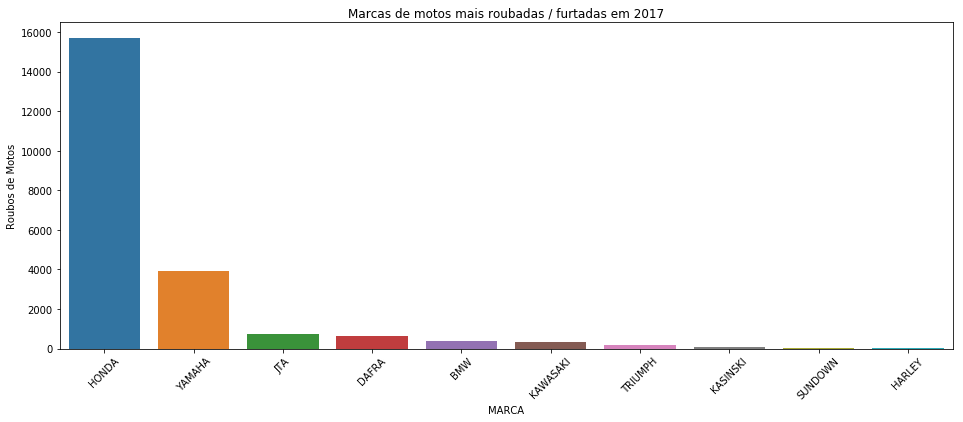

In [15]:
# MARCAS DE MOTO MAIS ROBADAS
carros_roubados = data.loc[data['TIPO_VEICULO'] == 'MOTO','MARCA']
ordem = carros_roubados.value_counts()[:10].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos de Motos")
plt.title("Marcas de motos mais roubadas / furtadas em 2017")
plt.show()

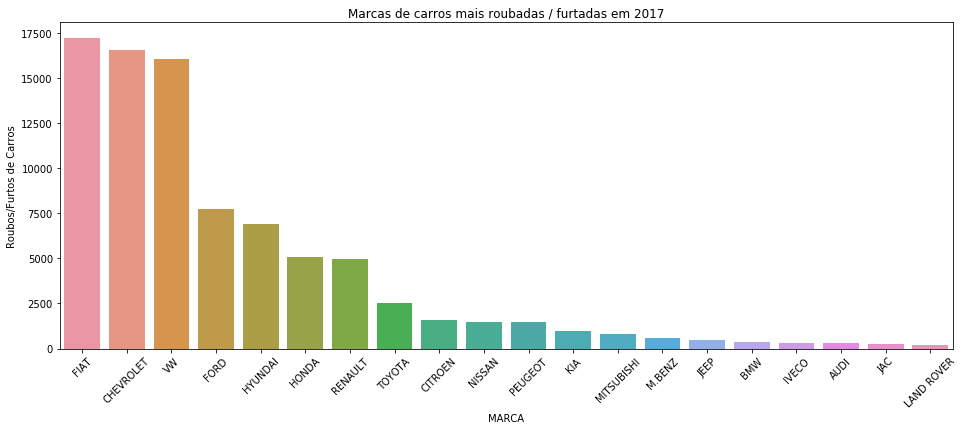

In [16]:
# Marcas de carros mais roubados
carros_roubados = data.loc[data['TIPO_VEICULO'] == 'AUTOMOVEL',['MARCA','ATO']]
ordem = carros_roubados['MARCA'].value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(x='MARCA', data=carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Carros")
plt.title("Marcas de carros mais roubadas / furtadas em 2017")
plt.show()

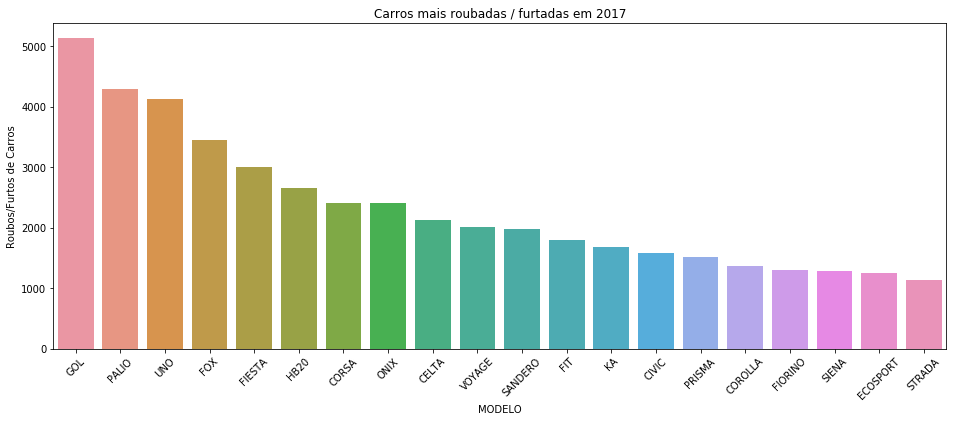

In [17]:
# Carros mais roubadas
carros_roubados = data.loc[data['TIPO_VEICULO'] == 'AUTOMOVEL',['MODELO','ATO']]
ordem = carros_roubados['MODELO'].value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(x='MODELO', data=carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Carros")
plt.title("Carros mais roubadas / furtadas em 2017")
plt.show()

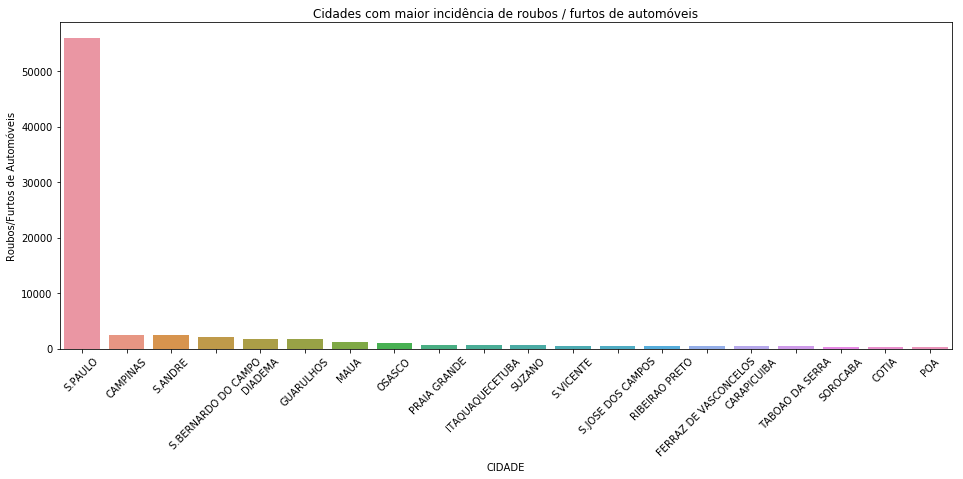

In [18]:
# Cidades com maior incidência de roubos - AUTOMOVEL
carros_roubados = data.loc[data['TIPO_VEICULO'] == 'AUTOMOVEL',['CIDADE','ATO']]
ordem = carros_roubados['CIDADE'].value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(x='CIDADE', data=carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Automóveis")
plt.title("Cidades com maior incidência de roubos / furtos de automóveis")
plt.show()

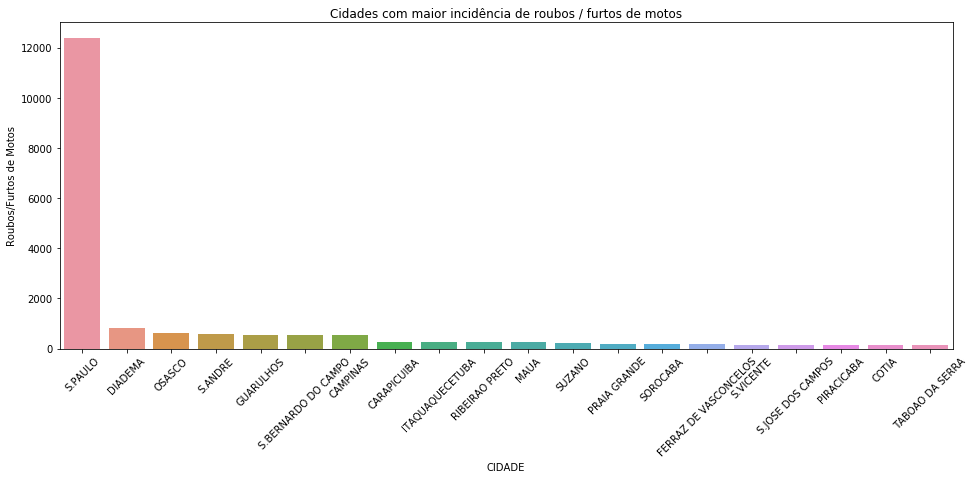

In [19]:
# Cidades com maior incidência de roubos - MOTOS
carros_roubados = data.loc[data['TIPO_VEICULO'] == 'MOTO',['CIDADE']]
ordem = carros_roubados['CIDADE'].value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(x='CIDADE', data=carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Motos")
plt.title("Cidades com maior incidência de roubos / furtos de motos")
plt.show()

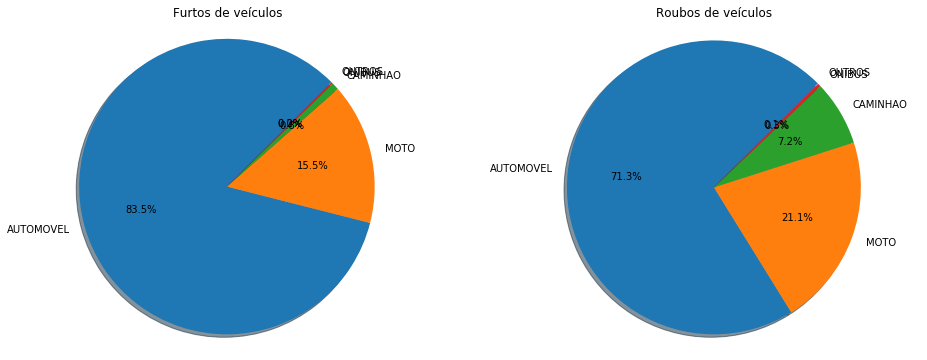

In [20]:
# Tipos de veículos mais roubados
fig, ax = plt.subplots(1,2, figsize=(16,6))
dados1 = pd.DataFrame(data.loc[data.ATO == "Furto - VEICULO",'TIPO_VEICULO'].value_counts())
dados2 = pd.DataFrame(data.loc[data.ATO == "Roubo - VEICULO",'TIPO_VEICULO'].value_counts())
plt.subplot(1,2,1)
plt.pie(dados1,labels=dados1.index,autopct='%1.1f%%', shadow=True, startangle=45)
plt.axis('equal')
plt.title('Furtos de veículos')
#plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(dados2,labels=dados2.index,autopct='%1.1f%%', shadow=True, startangle=45)
plt.axis('equal')
plt.title('Roubos de veículos')
#plt.tight_layout()
plt.show()

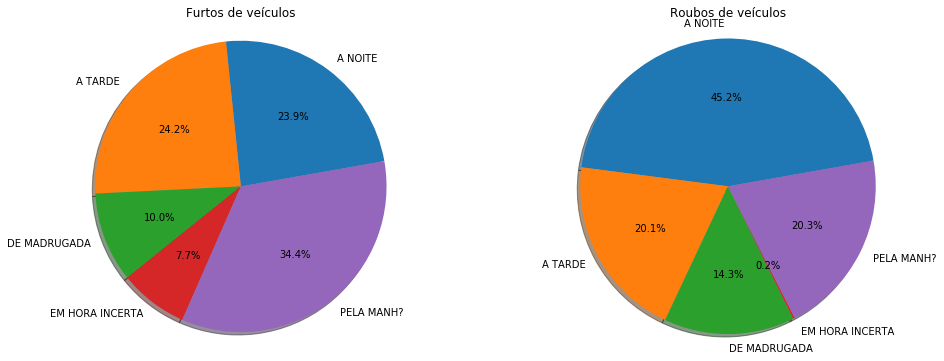

In [21]:
# Periodo do dia mais roubados
fig, ax = plt.subplots(1,2, figsize=(16,6))
dados1 = pd.DataFrame(data.loc[data.ATO == "Furto - VEICULO",'PERIDOOCORRENCIA'].value_counts()).sort_index()
dados2 = pd.DataFrame(data.loc[data.ATO == "Roubo - VEICULO",'PERIDOOCORRENCIA'].value_counts()).sort_index()
plt.subplot(1,2,1)
plt.pie(dados1,labels=dados1.index,autopct='%1.1f%%', shadow=True, startangle=10)
plt.axis('equal')
plt.title('Furtos de veículos')
#plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(dados2,labels=dados2.index,autopct='%1.1f%%', shadow=True, startangle=10)
plt.axis('equal')
plt.title('Roubos de veículos')
#plt.tight_layout()
plt.show()

In [ ]:
# Tipos de locais mais roubados
fig, ax = plt.subplots(1,2, figsize=(16,6))
dados1 = pd.DataFrame(data.loc[data.ATO == "Furto - VEICULO",'DESCRICAOLOCAL'].value_counts())
dados2 = pd.DataFrame(data.loc[data.ATO == "Roubo - VEICULO",'DESCRICAOLOCAL'].value_counts())
plt.subplot(1,2,1)
plt.pie(dados1,labels=dados1.index,autopct='%1.1f%%', shadow=True, startangle=50)
plt.axis('equal')
plt.title('Furtos de veículos')
#plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(dados2,labels=dados2.index,autopct='%1.1f%%', shadow=True, startangle=50)
plt.axis('equal')
plt.title('Roubos de veículos')
#plt.tight_layout()
plt.show()

In [ ]:
# Dia da semana mais roubadas
fig, ax = plt.subplots(1,2, figsize=(16,6))
dados1 = pd.DataFrame(data.loc[data.ATO == "Furto - VEICULO",'DIA_DA_SEMANA'].value_counts()).sort_index()
dados2 = pd.DataFrame(data.loc[data.ATO == "Roubo - VEICULO",'DIA_DA_SEMANA'].value_counts()).sort_index()
plt.subplot(1,2,1)
plt.pie(dados1,labels=dados1.index,autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.title('Furtos de veículos')
#plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(dados2,labels=dados2.index,autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.title('Roubos de veículos')
#plt.tight_layout()
plt.show()

In [ ]:
# Tipo de sexo dos praticante do crime
dados = data.loc[data.SEXO.notnull(),'SEXO']
plt.pie(dados.value_counts(),labels=dados.value_counts().index,autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Bairros em SAO PAULO CAPITAL com mais roubos
carros_roubados = data.loc[data['CIDADE'] == 'S.PAULO','BAIRRO']
ordem = carros_roubados.value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos")
plt.title("Bairros com maior incidência de roubos e furtos de veículos / motos")
plt.show()

In [ ]:
# Ruas com maior incidência de roubos em SAO PAULO CAPITAL
carros_roubados = data.loc[data['CIDADE'] == 'S.PAULO','LOGRADOURO']
ordem = carros_roubados.value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(carros_roubados, order=ordem)
plt.xticks(rotation=65)
plt.ylabel("Roubos/Furtos")
plt.title("Ruas com maior incidência de roubos e furtos de veículos / motos")
plt.show()

In [ ]:
# Modelos de carro mais roubados no bairro da Saúde
carros_roubados = data.loc[(data['TIPO_VEICULO'] == 'AUTOMOVEL') & (data['BAIRRO'] == 'SAUDE'),'MODELO']
ordem = carros_roubados.value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Carros")
plt.title('CARROS MAIS ROUBADOS NA SAÚDE')
plt.show()

In [ ]:
# Bairros que mais roubam LOGAN em SAO PAULO CAPITAL
carros_roubados = data.loc[(data['MODELO'] == 'LOGAN') & (data['CIDADE'] == 'S.PAULO'),'BAIRRO']
ordem = carros_roubados.value_counts()[:20].index
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(carros_roubados, order=ordem)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos")
plt.title('BAIRROS ONDE MAIS ROUBAM LOGAN')
plt.show()

In [ ]:
# Mêses com maior indices de roubo em 2017
carros_roubados = data.loc[:,'MES']
fig, ax = plt.subplots(1,1, figsize=(16,10))
sns.countplot(carros_roubados)
plt.xticks(rotation=45)
plt.ylabel("Roubos/Furtos de Carros e Motos")
plt.title('ROUBOS E FURTOS POR MES')
plt.show()

In [ ]:
import gmplot

heatmap = data.loc[(data.LATITUDE.notnull())&(data.LONGITUDE.notnull())&(data.CIDADE=="S.PAULO"),['LATITUDE','LONGITUDE']]
gmap = gmplot.GoogleMapPlotter.from_geocode("Sao Paulo")
gmap.heatmap(heatmap['LATITUDE'], heatmap['LONGITUDE'])
gmap.draw("sentinela_mapa_calor.html")

![](https://lh3.googleusercontent.com/7BE3IpTcNXn416iL_CAcpSUpR7Tnf7h7JgTId5_NyX_5W5uMRn8CpyeICQoqpjYC-zevF_m8LPgk3ldfA7cS=w3840-h1992)
![](https://lh3.googleusercontent.com/MPVGyOov89UXmAg8IG7TPUrTuaOULcuj03-bLFlMoGDOS-bKTdxNjERWjb2kSmqqHhzuLCb4XltuvMvnzRVQ=w3840-h1992)
![](https://lh4.googleusercontent.com/iTczxZfOKqfSn_GQtzpx4LotciRQkt5h8D_JX7ZY3tvMhJusMDjXl_-YGGNkA99YDkr_8yG3OLGqtIt0PLdb=w3840-h1992)

In [ ]:
# VISUALIZANDO O MOTO E O CARRO NA CAPITAL DE SAO PAULO
heatmap1 = data.loc[(data.LATITUDE.notnull())&(data.LONGITUDE.notnull())&(data.CIDADE == 'S.PAULO')&(data.TIPO_VEICULO == 'AUTOMOVEL'),['LATITUDE','LONGITUDE']]
heatmap2 = data.loc[(data.LATITUDE.notnull())&(data.LONGITUDE.notnull())&(data.CIDADE == 'S.PAULO')&(data.TIPO_VEICULO == 'MOTO'),['LATITUDE','LONGITUDE']]

gmap = gmplot.GoogleMapPlotter.from_geocode("Sao Paulo")
gmap.scatter(heatmap1['LATITUDE'], heatmap1['LONGITUDE'], '#FFA07A', size=30, marker=False)
gmap.scatter(heatmap2['LATITUDE'], heatmap2['LONGITUDE'], '#191970', size=30, marker=False)
gmap.draw("sentinela_pontos_ocorrencias.html")

As motocicletas estão em azul, os carros estão em laranja w aqui podemos ver que na Avenida Paulista, a rua mais importante da cidade, muitas motos foram roubadas! Muitos escritórios são estabelecidos em Av Paulista e a rua está cheia de motoboys.